# A Joint Fundamentals and Polling Dynamic Generalized Linear Model for

Predicting the Icelandic Parliamentary Elections

Brynjólfur Gauti Guðrúnar Jónsson  
Rafael Daniel Vias  
Hafsteinn Einarsson  
Agnar Freyr Helgason

# 1. Introduction

There is considerable public interest in election forecasting, a task that is complicated by the numerous mechanisms that may lead to a divergence between voting intentions as measured by pre-election polls and election results. Polling error refers to the accuracy of pre-election polls in terms of predicting election results but this is bound to be affected lead, referring to the time between the administration of the poll and the election ([Jennings, Lewis-Beck, and Wlezien 2020](#ref-jennings2020election)). Simply put, we should expect that the fewer days that remain until the election is held, the more accurate the polls and election forecasts will become, although even in the final days of the campaign considerable error, far exceeding sampling error alone, can be expected ([Jennings and Wlezien 2016](#ref-jennings2016timeline), [2018](#ref-jennings2018election)). Jennings, Lewis-Beck, and Wlezien ([2020](#ref-jennings2020election)) suggest that a lead of two or three months before an election occurs is often sufficient for creating accurate election forecasts.

However, the accuracy and lead of election forecasts may vary from country to country, as specific polling error mechanisms may be at work in some contexts but not in others. Survey methodologists rely on the Total Survey Error framework to decompose error sources which cause survey statistics to diverge from population parameters. Of these error sources, sampling error is almost always accounted for, but non-sampling errors such as coverage, nonresponse, measurement, and estimation errors often are not, although each can cause both systematic and variable errors ([Biemer 2010](#ref-biemer2010total); [Robert M. Groves and Lyberg 2010](#ref-groves2010total)). Prosser and Mellon ([2018](#ref-prosser2018twilight)) find that measurement error (“shy” voters) plays a limited role in polling error. Instead, the fact that voting intention is dynamic and problems with gathering representative samples and weighting are the primary causes of polling error. This suggest that nonresponse and estimation errors play important roles in polling error.

Nonresponse bias is the prime suspect in analyses of polling error and can be caused by various mechanisms. On the one hand, If the same characteristic predicts both response propensities and target variables (i.e. voting intentions), corresponding to a missing at random mechanism, bias can be adjusted in estimation by weighting on the characteristic, provided that it has been observed. On the other hand, if a target variable is the true cause of variation in response propensities, corresponding to a missing not at random mechanism, analyses of the target variable will be biased by nonresponse bias ([R. J. A. Little and Rubin 2020](#ref-little2020statistical); [Robert M. Groves 2006](#ref-groves2006nonresponse)). The latter scenario is easy to envisage in polls, where voters of specific parties may be more engaged in politics even when weighting adjustments for other characteristics are applied.

To address the issue of polling error, election forecasters often adjust for “house effects”, where some pollsters systematically over- or underestimate support for specific parties, relative to other pollsters ([Jennings and Wlezien 2018](#ref-jennings2018election)). Here, we add to the literature on election forecasting by adjusting for industry effects, referring to cases where polling error has been observed repeatedly and the direction in which it occurs as it relates to specific parties is consistent. This scenario would reflect an industry wide inability to recruit representative samples or to identify suitable auxiliary information to adjust for nonresponse bias as it relates to voting intention ([Kalton and Flores-Cervantes 2003](#ref-kalton2003weighting); [Robert M. Groves 2006](#ref-groves2006nonresponse)).

We put our assumptions to an empirical test by publishing an election forecast prior to the Icelandic parliamentary election of 2024. Response rates in Icelandic surveys have declined significantly over time but remain high in the international contexts **(Hvaða Einarsson er hvað í bibtex?)** (Einarsson et al., n.d.; Einarsson and Helgason, n.d.). However, most Icelandic pre-election polls are conducted using probability-based online panels. Online panels have mixed records when it comes to polling error but probability-based ones have been found to outperform non-probability ones ([Kennedy et al., n.d.](#ref-kennedy2016evaluation); [Callegaro et al. 2014](#ref-callegaro2014online)). However, the repeated selection of respondents carries significant risks in terms of panel conditioning ([Struminskaya and Bosnjak 2021](#ref-struminskaya2021panel)) and attrition ([Frankel and Hillygus 2014](#ref-frankel2014looking)). Therefore, online panels often rely heavily on model-based (rather than design-based) inference ([R. J. Little 2004](#ref-little2004model)), which will only be successful in the case that a suitable source of auxiliary information is identified.

Icelandic politics were characterised by remarkable stability prior to the 2008 financial crisis but have seen high electoral volatility since ([Önnudóttir et al. 2021](#ref-onnudottir2021electoral); [Helgason et al. 2022](#ref-helgason2022electoral)) . In fact, only one of the previous four governments has been able to serve a full four-year term, causing early elections in each instance, for a total of five elections in the span of 11 years. Each election has been associated with polling errors which can be attributed to the high degree of electoral volatility. Despite this, there has been little variation in voting intention estimates between polling houses and biases at the party level have been similar election-to-election, with right-wing parties being underestimated **(Hvaða bibtex er þetta?)** (Einarsson and Helgason, n.d.). This suggests that pollsters are relying on similar methods but failing to address the issue of polling error, i.e. industry effects may be at play.

As our model comes with significant assumptions regarding the direction of polling error, it is plausible that it may not improve the prediction of election outcomes. For example, if pollsters have identified new recruitment methods or identified weighting characteristics correlated both with the propensity to respond and target variables ([R. J. Little and Vartivarian 2005](#ref-little2005weighting)), our adjustments will introduce bias rather than adjust it. If, however, the same industry wide problems remain, our model will provide a more accurate picture of the voting intentions of the Icelandic electorate than an unadjusted polling average would.

# 2. Methods

This report outlines the methodology behind forecasting the outcome of the upcoming Icelandic Parliamentary Elections scheduled for November 30th. The forecast is based on a joint model that combines two components:

1.  A dynamic linear model for polling data that incorporates polling house effects and accounts for house-specific biases as well as overdispersion
2.  A fundamentals model that leverages historical election results, incumbency status, and previous vote shares

By combining these two sources of information, we aim to produce more accurate and robust forecasts that account for both the current state of public opinion and structural factors that influence election outcomes.

## 2.1 Model Specification

Our model combines two components:

1.  A dynamic linear model for polling data that captures temporal evolution of party support and polling house effects
2.  A fundamentals model that incorporates structural factors from historical election data

### 2.1.1 Notation

#### 2.1.1.1 Input Data

##### 2.1.1.1.1 Polling Data

-   $P$: Number of political parties *(including the Other category)*
-   $T$: Number of time points (dates), $1, \dots, T$, where $T$ is the date of the next election.
-   $H$: Number of polling houses
-   $N$: Number of observations (polls)
-   $y_{n,p}$: Count of responses for party $p$ in poll $n$
-   $\Delta_t$: The time difference between polls at $t-1$ and $t$ in days

##### 2.1.1.1.2 Fundamentals Data

-   $D_f$: Number of past elections
-   $P_f$: Number of parties in historical data
-   $y_{p,d}^{(f)}$: Vote share for party $p$ in election $d$
-   $x_{p,d}$: Previous vote share for party $p$ in election $d$
-   $I_{p,d}$: Years party $p$ has been incumbent at election $d$
-   $v_{p,d}$: Inflation rate (%) for party $p$ at election $d$ (if incumbent)
-   $g_{p,d}$: GDP growth rate (%) for party $p$ at election $d$ (if incumbent)

#### 2.1.1.2 Parameters

##### 2.1.1.2.1 Polling Model Parameters

-   $\beta_{p,t}$: Latent support for party $p$ at time $t$ (for $p = 2,\ldots,P$)
-   $\gamma_{p,h}$: Effect of polling house $h$ for party $p$ (for $p = 2,\ldots,P$)
-   $\mu_{\gamma,p}$: Mean house effect for party $p$
-   $\sigma_{\gamma,p}$: Scale of house effects for party $p$
-   $\sigma_p$: Scale parameter for the random walk of party $p$
-   $\phi$: Overdispersion parameter

##### 2.1.1.2.2 Fundamentals Model Parameters

-   $\alpha_p$: Base support level for party $p$
-   $\beta_{\text{lag}}$: Effect of previous vote share
-   $\beta_{\text{years inc}}$: Effect of log years as incumbent
-   $\beta_{\text{vnv}}$: Effect of excess inflation for incumbent parties
-   $\beta_{\text{growth}}$: Effect of GDP growth for incumbent parties
-   $\phi_f$: Overdispersion parameter for the fundamentals model
-   $\tau_f$: Scaling factor for the prior of the support during the next election

### 2.1.2 Data Preprocessing

The economic variables are transformed to better capture their effects:

-   Incumbent years are log-transformed: $\log(I_{p,d})$
-   Excess inflation is calculated as deviation from 2% target and log-transformed: $\log(1 + v_{p,d} - 0.02)$
-   GDP growth is log-transformed: $\log(1 + g_{p,d}/100)$

Both economic variables (inflation and growth) are only included for incumbent parties by multiplying them with the incumbency indicator. This allows us to specifically capture how economic performance during a party’s time in government affects their electoral prospects.

### 2.1.3 Polling Component

The polling model tracks party support over time using a centered logit transformation:

$$
\beta_{p,t} = \beta_{p,t + 1} + \sigma_p z_{p,t} \sqrt{\Delta_t} \quad \text{for } t = 2, \dots, T, \quad p=2, \dots, P
$$

where:

-   $\beta_{p,t}$ is the latent support for party $p$ at time $t$
-   $\sigma_p$ is the party-specific scale of random walk innovations
-   $z_{p,t} \sim \mathcal{N}(0, 1)$ are standardized innovations
-   $\sqrt{\Delta_t}$ scales the innovations according to time between polls

#### 2.1.3.1 Dynamic Latent Party Support

The initial states $\beta_{p,T}$ are linked to the fundamentals model through their prior:

$$
\beta_{p,T} \sim \mathcal{N}(\mu_{p,\text{pred}}, \tau_f  \cdot \sigma_p)
$$

where $\mu_{p,\text{pred}}$ comes from the fundamentals model prediction. Thus the polling component is set up as a backwards random walk starting at the next election, with a prior for the initial value set according to predictions from the fundamentals component.

The scaling-parameter $\tau_f$ can be interpreted as the weight the model gives to the polls as opposed to the fundamentals model. If $\tau_f$ is large, then $\beta_{p,T}$ is weakly informed by the fundamentals model, but if $\tau_f$ is small, then the fundamentals component is given more weight.

#### 2.1.3.2 Polling House Effects

Polling house effects are modeled hierarchically to account for systematic biases:

$$
\gamma_{p,1} = 0, \quad \gamma_{p,h} = \mu_{\gamma,p} + \sigma_{\gamma,p} \tilde{\gamma}_{p,h} \quad \text{for } h = 2, \dots, H,
$$

where $\tilde{\gamma}_{p,h} \sim \mathcal{N}(0, 1)$. The parameters $\mu_{\gamma,p}$ and $\sigma_{\gamma,p}$ control the mean and variability of polling house effects for each party.

Elections are set to be the first polling house and therefore $\gamma_{p,1} = 0$.

#### 2.1.3.3 Overdispersion

To account for overdispersion in the polling data, we introduce an overdispersion parameter $\phi$:

$$
\phi = \frac{1}{\phi_{\text{inv}}},
$$

where $\phi_{\text{inv}} \sim \text{Exponential}(1)$.

#### 2.1.3.4 Likelihood

The counts from polls and elections close to polls, $\mathbf y_n = \left( y_{n,1}, \dots, y_{n,P} \right)$ are modeled using a Dirichlet-Multinomial distribution:

$$
\begin{align}
\mathbf y_n &\sim \text{Dirichlet-Multinomial}\left(\sum_{p=1}^P y_{n,p}, \phi \cdot \boldsymbol \pi_n\right) \\
\boldsymbol \pi_n &= \mathrm{softmax}(\eta_n) \\
\eta_{n,p} &= \begin{cases} 
\beta_{p, t_n} + \gamma_{p, h_n} & p > 1 \\
-\sum_{p^*=2}^P \eta_{n,p^*} & p = 1
\end{cases}
\end{align}
$$

### 2.1.4 Fundamentals Component

The fundamentals model predicts the number of party votes based on:

$$
\begin{aligned}
y^{(f)} &\sim \text{Dirichlet-Multinomial}(\phi_f \cdot \pi) \\
\pi &= \mathrm{softmax}(\mu)\\
\mu_{p} &= \alpha_p + \beta_{\text{lag}} x_{p} + \beta_{\text{years inc}} \log(I{p}) + \beta_{\text{vnv}} \log(1 + v_p) + \beta_{\text{growth}} \log(1 + g_p)
\end{aligned}
$$

where:

-   $\alpha_p$ is the base support level for party $p$ (with $\alpha_1 = -\sum_{p=2}^P \alpha_p$)
-   $\beta_{\text{lag}}$ is the effect of zero-centered logit transformed vote shares $x_p$ from the previous election
-   $\beta_{\text{years inc}}$ is the effect of the log number of years as incumbent where $I_p$ is the number of years
-   $\beta_{\text{vnv}}$ is the effect of inflation (%), where $v_p$ is the yearly inflation rate (only for incumbent parties), measured six months before the election
-   $\beta_{\text{growth}}$ is the effect of GDP growth (%) $g_p$ (only for incumbent parties), measured six months before the election
-   $\phi_f$ is an overdispersion parameter for the fundamentals model

This creates a hierarchical structure where the fundamentals model informs the prior for the outcome of the elections, but the backwards random walk along with the polling data updates that prior according to the current latent support.

The economic variables (inflation and growth) are only included for incumbent parties through multiplication with the incumbency indicator, allowing us to capture how economic performance during a party’s time in government affects their electoral prospects.

## 2.2 Inference

Bayesian inference is performed using Markov Chain Monte Carlo (MCMC) sampling via Stan. Posterior distributions of the latent party support $\beta_{p,t}$ are obtained, allowing for probabilistic forecasting of election outcomes.

# 3. Results

## 3.1 Parameter Estimates

### 3.1.1 Polling Component

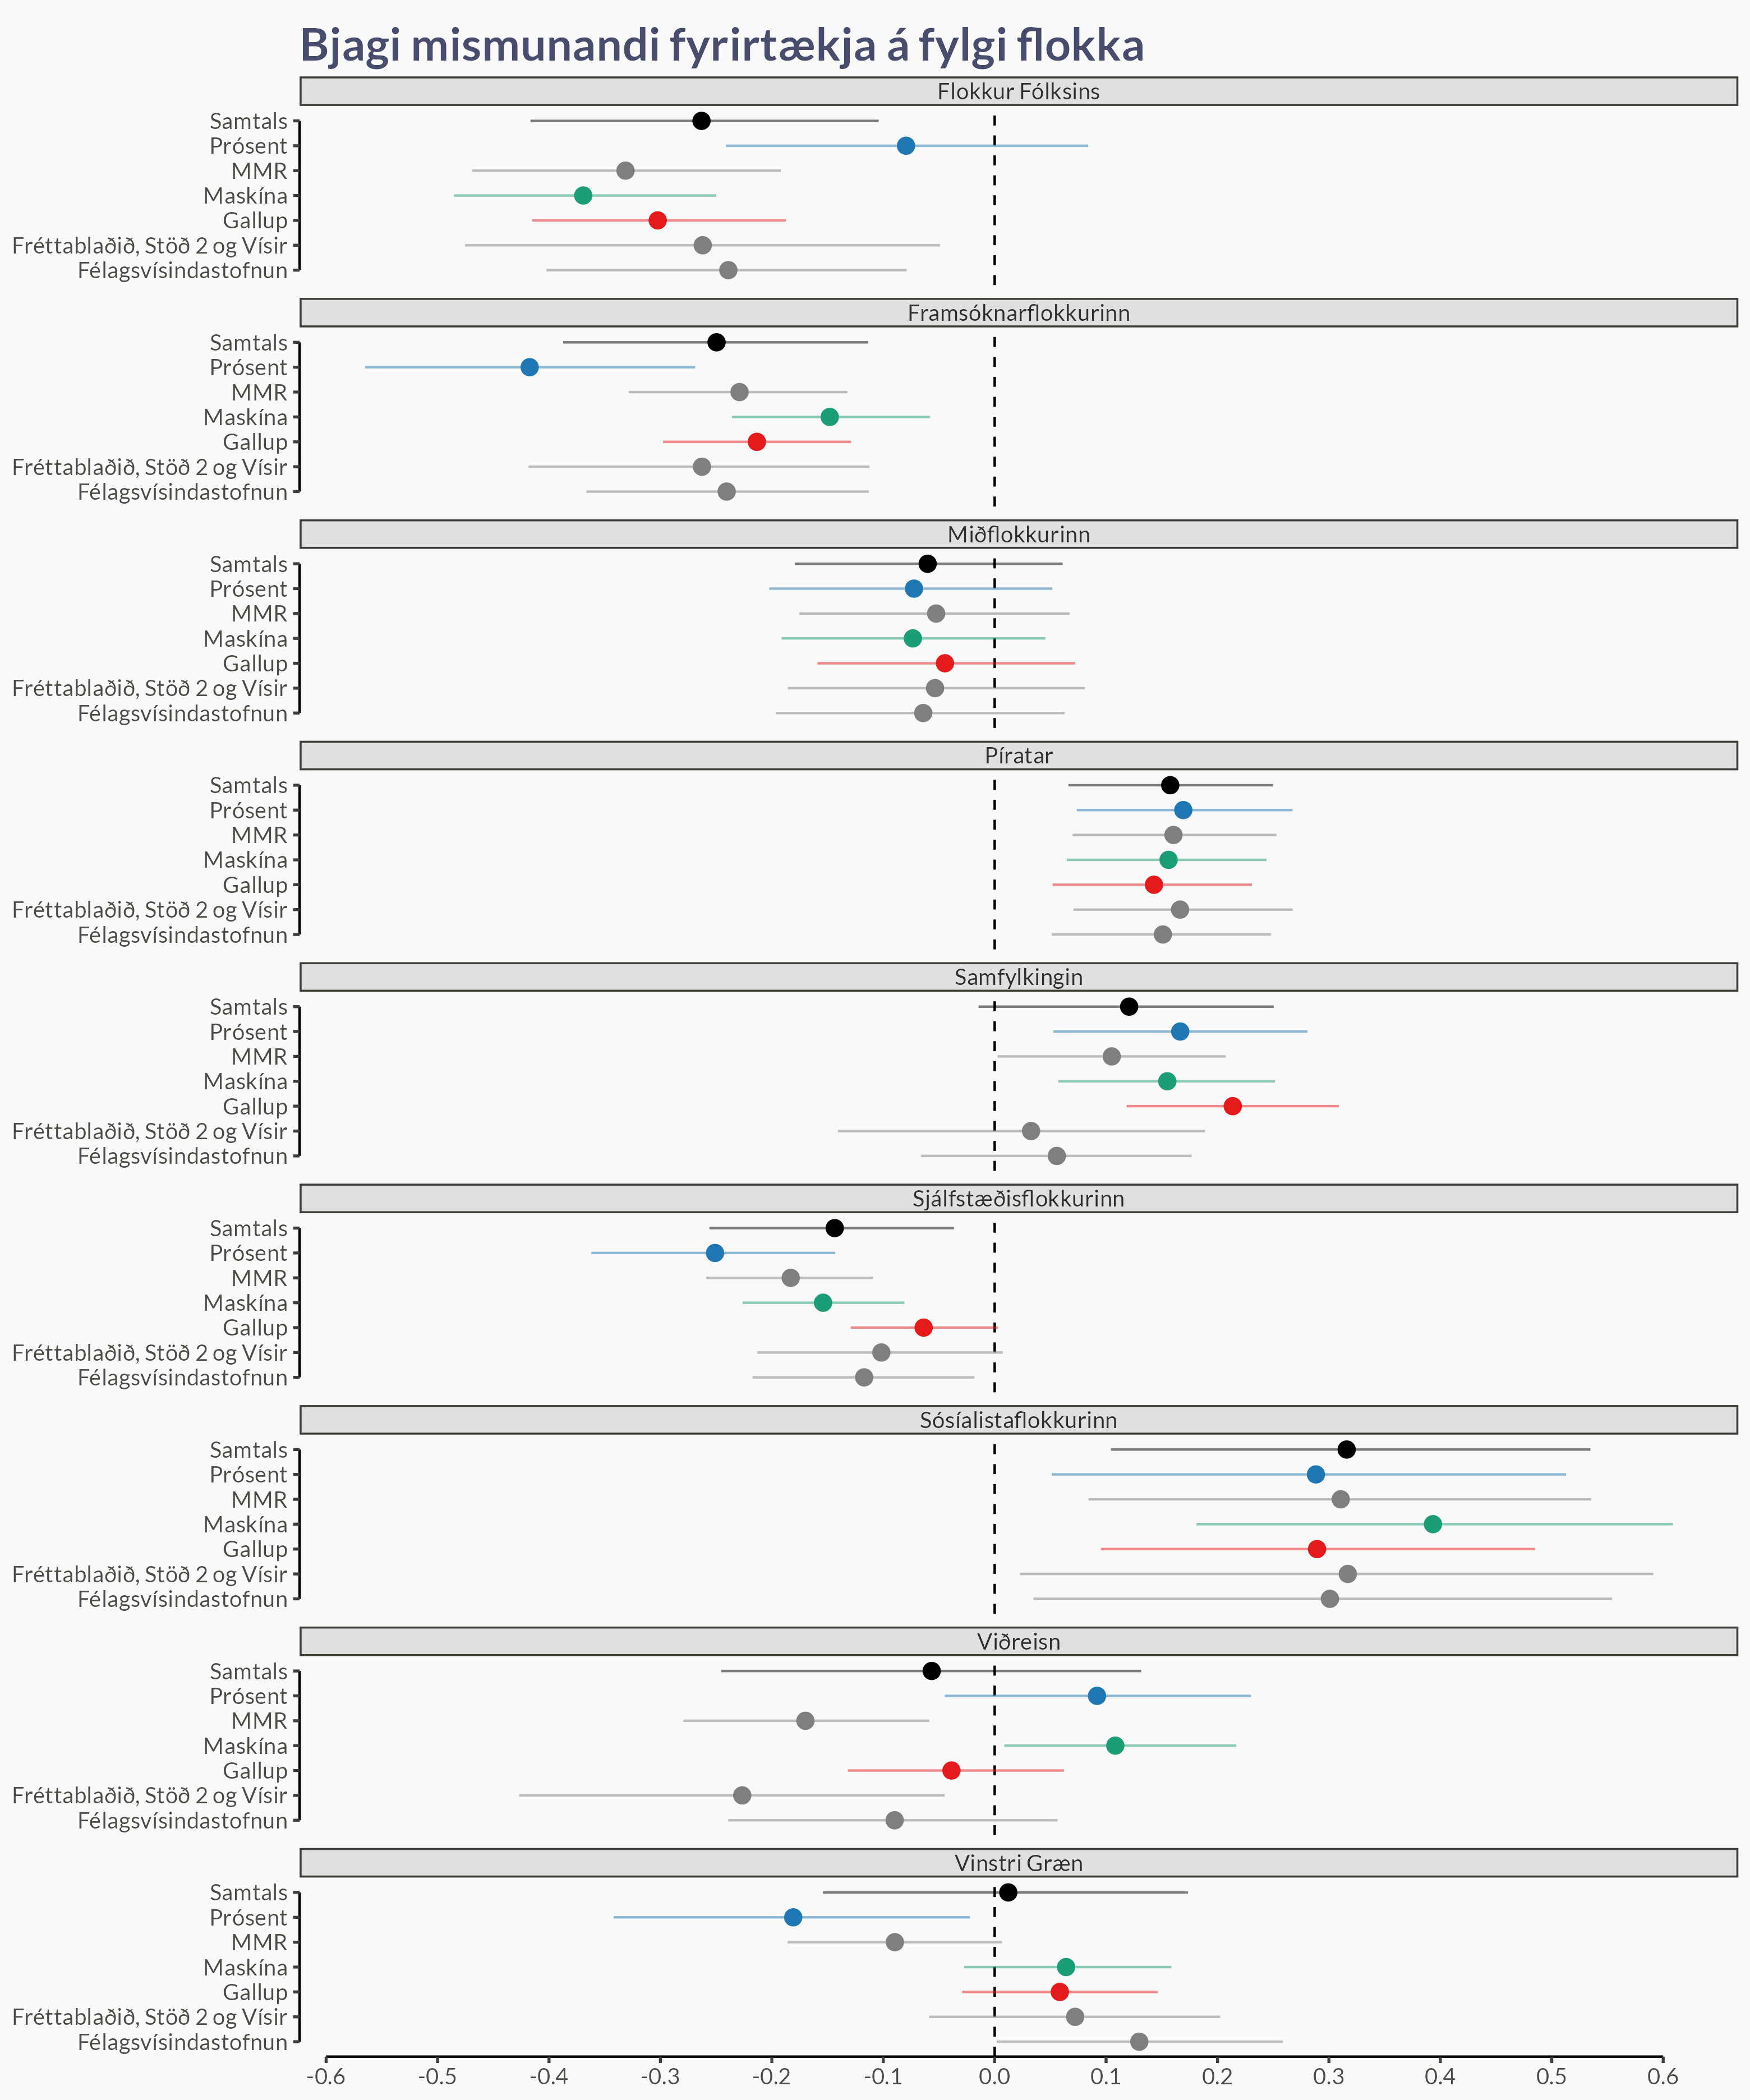

### 3.1.2 Fundamentals Component

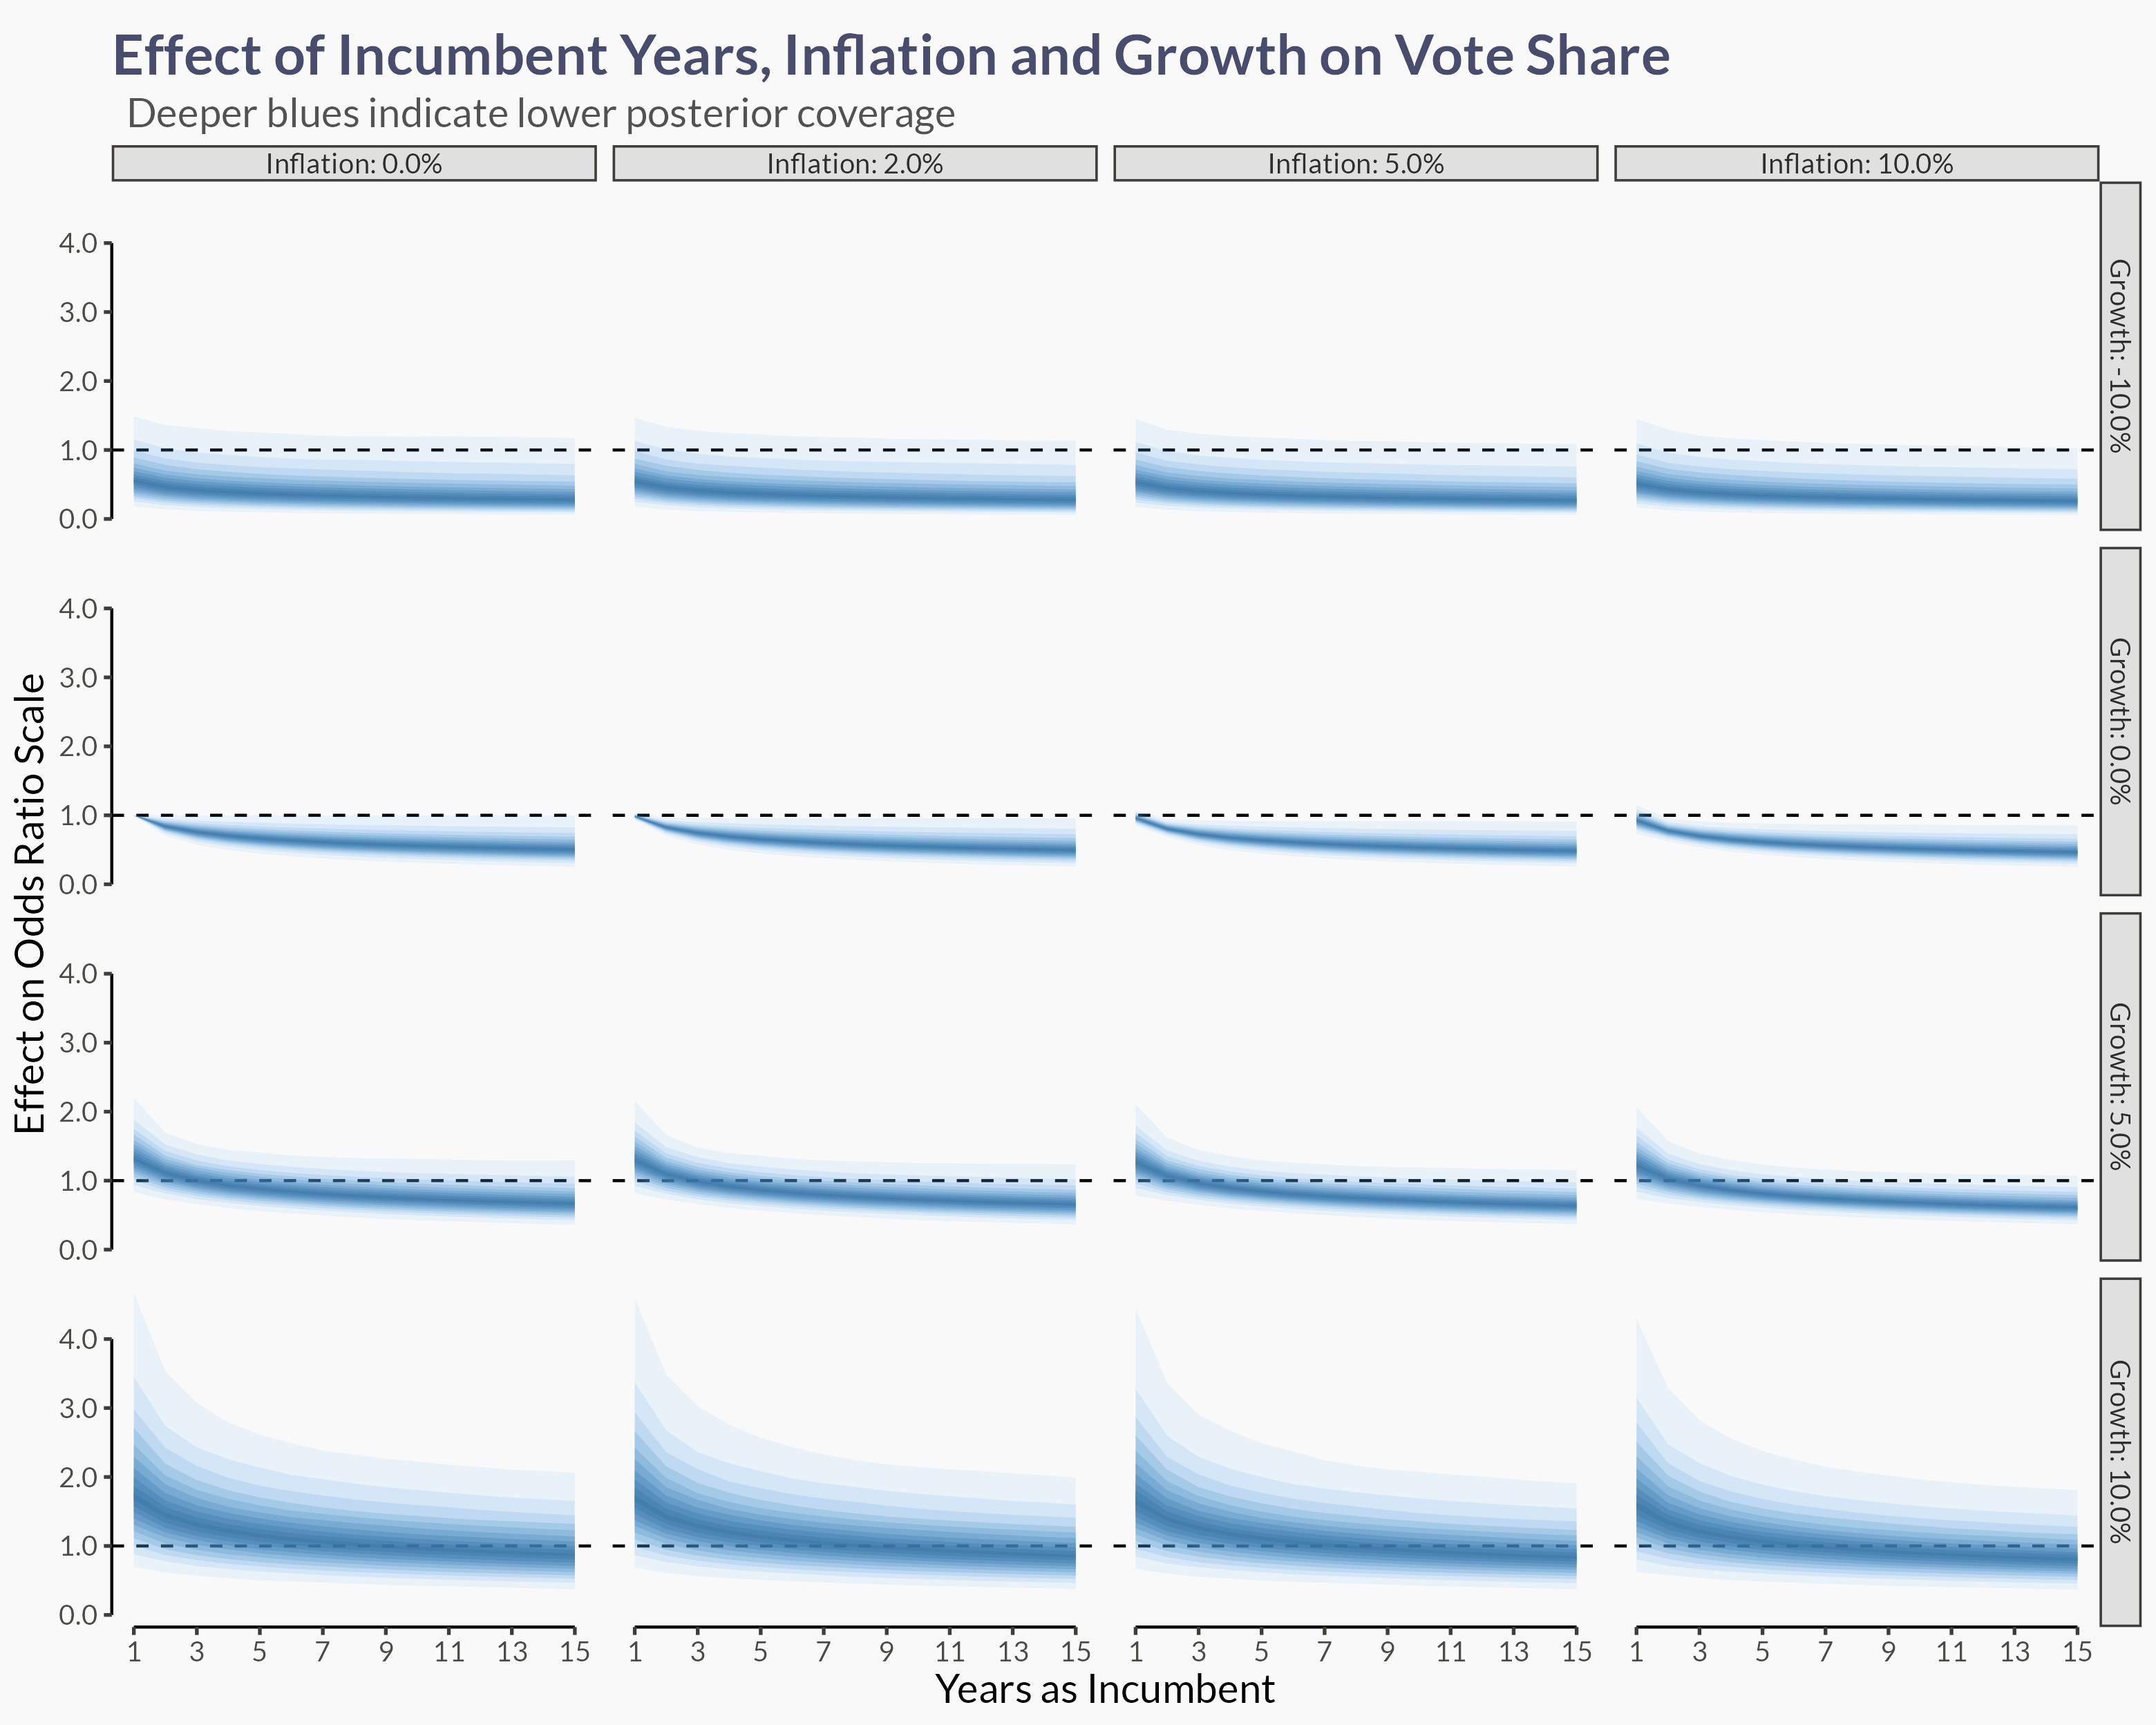

## 3.2 Prediction

In [ ]:
source("R/plot_model_results.R")
make_plot()

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: scales


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor


here() starts at /Users/brynjolfurjonsson/Metill/R/kosningaspa


Attaching package: 'arrow'


The following object is masked from 'package:lubridate':

    duration


The following object is masked from 'package:utils':

    timestamp


Rows: 3330 Columns: 4
── Column spe

ℹ It has been replaced by a ggproto system that can be extended.

(`geom_interactive_point()`).

Warning in set_attr(name = attrName, ids = as.integer(ids), values =
attrValue): Failed setting attribute 'data-id', mismatched lengths of ids and
values (most often, it occurs because of clipping or because of NAs in data)
Warning in set_attr(name = attrName, ids = as.integer(ids), values =
attrValue): Failed setting attribute 'data-id', mismatched lengths of ids and
values (most often, it occurs because of clipping or because of NAs in data)
Warning in set_attr(name = attrName, ids = as.integer(ids), values =
attrValue): Failed setting attribute 'data-id', mismatched lengths of ids and
values (most often, it occurs because of clipping or because of NAs in data)
Warning in set_attr(name = attrName, ids = as.integer(ids), values =
attrValue): Failed setting attribute 'data-id', mismatched lengths of ids and
values (most often, it occurs because of clipping or because of NAs in data)
Warning in set_attr(name = attrName, ids = as.integer(ids), values =
attrValue): Failed setting attribut

# 4. Discussion

# 5. Appendix

## 5.1 Choosing $\tau_f$

To choose how we want to calculate the standard deviation for prior on $\beta_T$, we can frame our model as a Gaussian-Gaussian conjugate problem where:

-   The prior (fundamentals prediction) is: $\beta_T \sim \mathcal{N}(\mu_{\text{pred}}, \tau_f \cdot \sigma)$
-   The likelihood (polling prediction from time t) is: $\beta_T \sim \mathcal{N}(\beta_t, V(t) \cdot \sigma)$

where $V(t)$ represents the accumulated variance from time t to election time T:

-   For $t \leq 47$ (after government split): $V(t) = t \cdot (1 + \tau_{\text{stjornarslit}})^2$
-   For t \> 47 (before government split): $V(t) = (t - 47) + 47 \cdot (1 + \tau_{\text{stjornarslit}})^2$

Using standard Gaussian-Gaussian conjugate formulas:

$$
\begin{aligned}
\text{Posterior precision} &= \frac{1}{(\tau_f \cdot \sigma)^2} + \frac{1}{V(t) \cdot \sigma^2} \\
&= \left(\frac{1}{\tau_f^2} + \frac{1}{V(t)}\right) \cdot \frac{1}{\sigma^2}
\end{aligned}
$$

For a desired fundamentals weight w at time t:

$$
w = \frac{1/\tau_f^2}{1/\tau_f^2 + 1/V(t)}
$$

Solving for $\tau_f$:

$$
\tau_f = \sqrt{V(t) \cdot (1-w)/w}
$$

where $V(t)$ depends on $\tau_{\text{stjornarslit}}$ as defined above. As an example, if we choose $w = \frac13$ and $t = 180$, we get:

$$
\begin{aligned}
V(180) &= (180 - 47) + 47 \cdot (1 + \tau_{\text{stjornarslit}})^2 \\
&= 133 + 47 \cdot (1 + \tau_{\text{stjornarslit}})^2
\end{aligned}
$$

Then:

$$
\begin{aligned}
\tau_f &= \sqrt{V(180) \cdot (1-\frac{1}{3})/\frac{1}{3}} \\
&= \sqrt{(133 + 47 \cdot (1 + \tau_{\text{stjornarslit}})^2) \cdot 2} \\
&= \sqrt{266 + 94 \cdot (1 + \tau_{\text{stjornarslit}})^2}
\end{aligned}
$$

This shows how $\tau_f$ adapts to the estimated value of $\tau_{\text{stjornarslit}}$ in our model, increasing when there is more uncertainty during the government split period.

Biemer, Paul P. 2010. “Total Survey Error: Design, Implementation, and Evaluation.” *Public Opinion Quarterly* 74 (5): 817–48. <https://doi.org/10.1093/poq/nfq058>.

Callegaro, Mario, Reg Baker, A. S. Göritz, Jon A. Krosnick, and Paul J. Lavrakas. 2014. *Online Panel Research: A Data Quality Perspective*. Edited by Mario Callegaro, Reg Baker, A. S. Göritz, Jon A. Krosnick, and Paul J. Lavrakas. Chichester: John Wiley & Sons.

Frankel, Laura Lazarus, and D. Sunshine Hillygus. 2014. “Looking Beyond Demographics: Panel Attrition in the ANES and GSS.” *Political Analysis* 22 (3): 336–53. <https://doi.org/10.1093/pan/mpt020>.

Groves, Robert M. 2006. “Nonresponse Rates and Nonresponse Bias in Household Surveys.” *Public Opinion Quarterly* 70 (5): 646–75. <https://doi.org/10.1093/poq/nfl033>.

Groves, Robert M, and Lars Lyberg. 2010. “Total Survey Error: Past, Present, and Future.” *Public Opinion Quarterly* 74 (5): 849–79. <https://doi.org/10.1093/poq/nfq065>.

Helgason, Agnar Freyr, Ólafur Þ. Harðarson, Jón Gunnar Ólafsson, Eva H. Önnudóttir, and Hulda Þórisdóttir. 2022. “Electoral Politics After the Crisis: Change, Fluctuations and Stability in the 2021 Althingi Election.” *Icelandic Review of Politics and Administration* 18 (1): 1–26. <https://doi.org/10.13177/irpa.a.2022.18.1.1>.

Jennings, Will, Michael Lewis-Beck, and Christopher Wlezien. 2020. “Election Forecasting: Too Far Out?” *International Journal of Forecasting* 36 (3): 949–62. <https://doi.org/10.1016/j.ijforecast.2019.12.002>.

Jennings, Will, and Christopher Wlezien. 2016. “The Timeline of Elections: A Comparative Perspective.” *American Journal of Political Science* 60 (1): 219–33. <https://doi.org/10.1111/ajps.12189>.

———. 2018. “Election Polling Errors Across Time and Space.” *Nature Human Behaviour* 2 (4): 276–83. <https://doi.org/10.1038/s41562-018-0315-6>.

Kalton, Graham, and Ismael Flores-Cervantes. 2003. “Weighting Methods.” *Journal of Official Statistics* 19 (2): 81–97.

Kennedy, Courtney, Mark Blumenthal, Scott Clement, Joshua D Clinton, Claire Durand, Charles Franklin, and et al. Mcgeeney Kyley. n.d. “An Evaluation of 2016 Election Polls in the US.”

Little, Roderick J. 2004. “To Model or Not to Model? Competing Modes of Inference for Finite Population Sampling.” *Journal of the American Statistical Association* 99 (466): 546–56. <https://doi.org/10.1198/016214504000000467>.

Little, Roderick J. A., and Donald B. Rubin. 2020. *Statistical Analysis with Missing Data*. 3rd ed. Hoboken, NJ: John Wiley & Sons, Inc. <https://doi.org/10.2307/3172915>.

Little, Roderick J., and Sonya Vartivarian. 2005. “Does Weighting for Nonresponse Increase the Variance of Survey Means?” *Survey Methodology* 31 (2): 161–68.

Önnudóttir, Eva H., Agnar Freyr Helgason, Ólafur Th. Hardarson, and Hulda Thórisdóttir. 2021. *Electoral Politics in Crisis After the Great Recession*. London: Routledge. <https://doi.org/10.4324/9780429436345>.

Prosser, Christopher, and Jonathan Mellon. 2018. “The Twilight of the Polls? A Review of Trends in Polling Accuracy and the Causes of Polling Misses.” *Government and Opposition* 53 (4): 757–90. <https://doi.org/10.1017/gov.2018.7>.

Struminskaya, Bella, and Michael Bosnjak. 2021. “Panel Conditioning: Types, Causes, and Empirical Evidence of What We Know so Far.” In *Advances in Longitudinal Survey Methodology*, edited by Peter Lynn, 272–301. Hoboken, NJ: Wiley.